SIMULATION OF SYSTEMS OF RANDOM VALUES

In [1]:
from IPython.display import display, Math
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
TM_TEX = r"\text {Theoretical distribution matrix of a two-dimensional DRV =}"
PM_TEX = r"\text {Empirical distribution matrix of a two-dimensional DRV =}"

In [3]:
def bmatrix(a: np.array) -> str:
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError("bmatrix can at most display two dimensions")
    lines = str(a).replace("[", "").replace("]", "").splitlines()
    rv = [r"\begin{bmatrix}"]
    rv += [" " + " & ".join(l.split()) + r"\\" for l in lines]
    rv += [r"\end{bmatrix}"]
    return "\n".join(rv)

In [4]:
def calculate_variance_theoretical(xi: np.array, pi: np.array, M: float) -> float:
    return np.sum(xi ** 2 * pi) - M ** 2


def calculate_variance_empirical(X: np.array, M: float) -> float:
    return sum((x - M) ** 2 for x in X) / (len(X) - 1)


def confidence_interval_variance(N: int, D: float, alpha: float) -> tuple[float, float]:
    left = (N - 1) * D / stats.chi2.ppf(alpha + (1 - alpha) / 2, df=N - 1)
    right = (N - 1) * D / stats.chi2.ppf((1 - alpha) / 2, df=N - 1)
    return left, right


def confidence_interval_correlation(r: float, t: float, N: int) -> tuple[float, float]:
    left = r - t * (1 - r ** 2) / N ** 0.5
    right = r + t * (1 - r ** 2) / N ** 0.5
    return left, right


def calculate_bivariate_distribution_function(F: np.array) -> np.array:
    # формируем двумерную функцию распределния
    Fn = np.zeros_like(F)
    for i in range(F.shape[0]):
        for j in range(F.shape[1]):
            Fn[i, j] = F[:i + 1, :j + 1].sum()
    return Fn


def check_borders(left: float, right: float, value: float) -> bool:
    return True if left < value < right else False


def display_confidence_intervals(E: float, D: float, N: int, letter: str) -> None:
    for alpha in (0.99, 0.98, 0.95):
        ok = 0
        mean_left, mean_right = stats.norm.interval(alpha=alpha, loc=E, scale=(D / N) ** 0.5)
        variance_left, variance_right = confidence_interval_variance(N, D, alpha)
        if check_borders(mean_left, mean_right, E):
            display(Math(f"{letter}" + r'\text { Confidence intervals for alpha=}' + str(alpha)))
            display(Math(r'\mathrm{E}' + f'({letter})' + r'\text { in interval }' + f"({mean_left} : {mean_right})"))
            ok += 0.5
        if check_borders(variance_left, variance_right, D):
            display(Math(
                r'\operatorname{Var}' + f'({letter})' + r'\text { in interval }' + f"({variance_left} : {variance_right})"))
            ok += 0.5
        if bool(ok): break

In [5]:
def calc_estimates_empirical(T: np.array, P: np.array, X: np.array, Y: np.array, Y_th: np.array,
                             X_th: np.array) -> None:
    # Подсчет империческое матожидания для случайных величин X и Y
    # E[X]=ΣXi / N
    Mx, My = np.mean(X), np.mean(Y)
    # Подсчет империческое дисперсии для случайных величин X и Y
    Dx, Dy = calculate_variance_empirical(X, Mx), calculate_variance_empirical(Y, My)
    # Подсчет среднего квадратическим отклонения для случайных величин X и Y
    # σ(X)=√D
    sigma_x = Dx ** 0.5
    sigma_y = Dy ** 0.5
    # Подсчет ковариации для случайных величин X и Y
    cov_XY = sum((x - Mx) * (y - My) for (x, y) in zip(X, Y)) / (len(X) - 1)
    # Подсчет корреляции для случайных величин X и Y
    r_XY = cov_XY / (sigma_x * sigma_y)
    # Вывод результатов
    print("Empirical")
    display(Math(r'\mathrm{E}[X]=\sum_{i=1}^{k} x_{i} px_{i}=' + str(Mx) + r',\ \mathrm{E}[Y]=\sum_{i=1}^{k} y_{i} py_{i}=' + str(My)))
    display(Math(r'\operatorname{Var}(X)=' + str(Dx) + r'\ \operatorname{Var}(Y)=' + str(Dy)))
    display(Math(r'\sigma(X)=\sqrt{\frac{\sum\left(x_{i}-\mu\right)^{2}}{N}}=' + str(sigma_x)))
    display(Math(r'\sigma(Y)=\sqrt{\frac{\sum\left(y_{i}-\mu\right)^{2}}{N}}=' + str(sigma_y)))
    display(Math(r'\operatorname{cov}(X, Y)=\mathrm{E}[(X-\mathrm{E}[X])(Y-\mathrm{E}[Y])]=' + str(cov_XY)))
    display(Math(
        r'\rho_{X, Y}=\operatorname{corr}(X, Y)=\frac{\operatorname{cov}(X, Y)}{\sigma_{X} \sigma_{Y}}=' + str(r_XY)))
    # Confidence interval матожидание, дисперсия, корреляция
    print("Confidence intervals матожидание, дисперсия, корреляция")
    display_confidence_intervals(E=Mx, D=Dx, N=len(X), letter="X")
    display_confidence_intervals(E=My, D=Dy, N=len(X), letter="Y")
    # Student's t-test for a = 0.05 and df=inf
    # r_left, r_right = confidence_interval_correlation(r=r_XY, t=1.96, N=len(X))
    # display(Math(r'\text {Confidence intervals for correlation }\rho_{X, Y}=' + f"({r_left}:{r_right})"))

    # Критерий Колмогорова
    # формируем функции распределния для теор и импер
    print("Функции распределния")
    Fn = calculate_bivariate_distribution_function(P)
    F = calculate_bivariate_distribution_function(T)
    display(Math(r'F(x, y) = P(X <= x, Y <= y) \ =>  \ Empirical= {} \ Theoretical={}  \\'.format(bmatrix(Fn), bmatrix(F))))
    # проверяем критерий D_{n}=\sup _{x \in \mathbb{R}}\left|F_{n}(x)-F(x)\right|
    D = max(abs(Fn[i, j] - F[i, j]) for i in range(len(X_th)) for j in range(len(Y_th)))
    critical = 1.36 / (len(X) ** 0.5)
    print("Критерий Колмогорова")
    display(Math(r'\text {На уровне значимости a=0.01, допустимое значение D=.}' + str(critical)))
    display(Math(r'\text {Проверяем гипотезу H0, получаем значение D=}' + str(D)))
    display(Math(
        r'\text {Поэтому на уровне значимости a=0.1 нулевую гипотезу H0 принимаем.}')) if D < critical else display(
        Math(r'\text {Поэтому на уровне значимости a=0.1 нулевую гипотезу H0 отвергаем.}'))


In [6]:
def calc_estimates_theoretical(T: np.array, X: np.array, Y: np.array) -> None:
    # Подсчет теоретического матожидания для случайных величин X и Y
    # E[X]=Σxi*pi
    X_p, Y_p = np.sum(T, axis=1), np.sum(T, axis=0)
    Mx, My = np.sum(X_p * X), np.sum(Y_p * Y)
    # Подсчет теоретической дисперсии для случайных величин X и Y
    # D[X]=M(X^2)-M(X)^2
    Dx, Dy = calculate_variance_theoretical(X, X_p, Mx), calculate_variance_theoretical(Y, Y_p, My)
    # Подсчет среднего квадратическим отклонения для случайных величин X и Y
    # σ(X)=√D
    sigma_x = Dx ** 0.5
    sigma_y = Dy ** 0.5
    # Подсчет ковариации для случайных величин X и Y
    # cov(X,Y)=ΣΣ(X-M(X))(Y-M(X))*Tij
    cov_XY = np.sum([(X[i] - Mx) * (Y[j] - My) * T[i][j] for i in range(len(X)) for j in range(len(Y))])
    # Подсчет корреляции для случайных величин X и Y
    # r(X,Y)=cov(X,Y)/σ(X)σ(Y)
    r_XY = cov_XY / (sigma_x * sigma_y)
    # Вывод результатов
    print("Theoretical")
    display(Math(r'\mathrm{E}[X]=\sum_{i=1}^{k} x_{i} px_{i}=' + str(Mx) + r', \ \mathrm{E}[Y]=\sum_{i=1}^{k} y_{i} py_{i}=' + str(My)))
    display(Math(r'\operatorname{Var}(X)=' + str(Dx)))
    display(Math(r'\operatorname{Var}(Y)=' + str(Dy)))
    display(Math(r'\sigma(X)=\sqrt{\frac{\sum\left(x_{i}-\mu\right)^{2}}{N}}=' + str(sigma_x)))
    display(Math(r'\sigma(Y)=\sqrt{\frac{\sum\left(y_{i}-\mu\right)^{2}}{N}}=' + str(sigma_y)))
    display(Math(r'\operatorname{cov}(X, Y)=\mathrm{E}[(X-\mathrm{E}[X])(Y-\mathrm{E}[Y])]=' + str(cov_XY)))
    display(Math(
        r'\rho_{X, Y}=\operatorname{corr}(X, Y)=\frac{\operatorname{cov}(X, Y)}{\sigma_{X} \sigma_{Y}}=' + str(r_XY)))

In [7]:
def simulation_random_value(T: np.array) -> tuple[int, int]:
    """Returns a random matrix index

    :T: Theoretical distribution matrix of a two-dimensional: np.array
    :returns: tuple of matrix index
    """
    q = np.sum(T, axis=1).tolist()
    l = [sum(q[:i - 1]) for i in range(1, len(q) + 2)]
    random_number = np.random.uniform()
    for i in range(len(T)):
        if l[i] < random_number <= l[i + 1]:
            for j in range(len(T[i])):
                if sum(T[i][:j + 1]) + l[i] >= random_number:
                    return i, j

In [8]:
def show_histogram(values: np.arange, component_name: str) -> None:
    sns.set_style("darkgrid")
    plt.figure(dpi=120, figsize=(8, 5))
    plt.hist(values, color=sns.color_palette('deep')[4], linewidth=2)
    plt.title("Histogram of " + component_name + " component of DRV")
    plt.xlabel("Value")
    plt.ylabel("Amount")
    # sns.histplot(values, palette='deep', color=sns.color_palette('deep')[1], linewidth=2, binwidth=0.4)
    plt.legend((component_name + " component", ''))
    plt.show()

In [9]:
def generate_empirical_matrix(T: np.array, X: np.array, Y: np.array, P: np.array, num_attempts: int) -> np.array:
    """Empirical distribution matrix of a two-dimensional DRV

    :T: Theoretical distribution matrix of a two-dimensional: np.array
    :P: Zeros matrix: np.array
    :num_attempts: Number of draws: int
    :returns
    :P: Empirical distribution matrix as a np.array,
    :emp_dis_rv_X: Empirical distribution of a random variable X as a np.array,
    :emp_dis_rv_Y: Empirical distribution of a random variable Y as a np.array,
    """
    empirical_X = []
    empirical_Y = []
    for i in range(num_attempts):
        i, j = simulation_random_value(T)
        P[i][j] += 1
        empirical_X.append(X[i])
        empirical_Y.append(Y[j])
    show_histogram(empirical_X, "X")
    show_histogram(empirical_Y, "Y")
    P /= num_attempts
    display(Math(r'{} {} \\'.format(TM_TEX, bmatrix(T))))
    display(Math(r'{} {} \\'.format(PM_TEX, bmatrix(P))))
    return P, empirical_X, empirical_Y

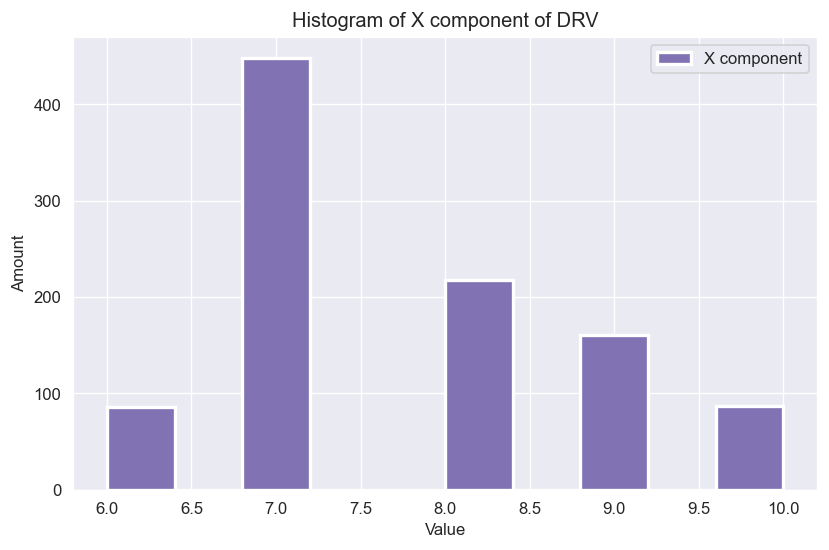

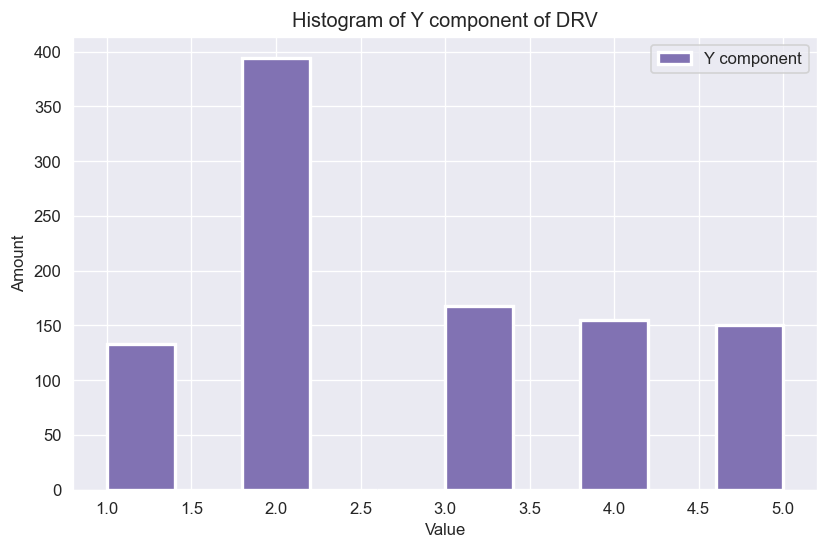

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Theoretical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Empirical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Confidence intervals матожидание, дисперсия, корреляция


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Функции распределния


<IPython.core.display.Math object>

Критерий Колмогорова


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
Y = np.array([1, 2, 3, 4, 5])
X = np.array([6, 7, 8, 9, 10])
theoretical_prob = np.array([
    [0.01, 0.01, 0.02, 0.02, 0.01],
    [0.04, 0.3, 0.06, 0.03, 0.01],
    [0.02, 0.03, 0.06, 0.07, 0.05],
    [0.05, 0.03, 0.04, 0.02, 0.03],
    [0.03, 0.02, 0.01, 0.01, 0.02]
])
empirical_prob, X_data, Y_data = generate_empirical_matrix(
    P=np.zeros_like(theoretical_prob),
    X=X, Y=Y, T=theoretical_prob,
    num_attempts=1000
)
calc_estimates_theoretical(X=X, Y=Y, T=theoretical_prob)
calc_estimates_empirical(T=theoretical_prob, P=empirical_prob, X=X_data, Y=Y_data, Y_th=Y, X_th=X)